In [1]:
import numpy as np
import cupy as cp
from scipy.spatial.distance import cdist
from visualize import *

# Kernel
Kernel is defined as:
## $$ k(x,x')=e^{-\gamma_s {\lVert S(x)-S(x')\rVert}^2}e^{-\gamma_c {\lVert C(x)-C(x')\rVert}^2} $$

In [2]:
def computeKernel(X, gamma_s=0.025, gamma_c=0.025, H=100, W=100):
    # X: Nxk (N: #features = H * W, k: dimension of each feature)
    # output: Gram matrix K, NxN
    
    indices = np.transpose(np.indices((H, W), dtype=np.float), (1, 2, 0)).reshape(-1, 2)
    dist_s = cdist(indices, indices, 'sqeuclidean')
    dist_s /= np.max(dist_s)
    
    dist_c = cdist(X, X, 'sqeuclidean')
    
    return np.exp(-gamma_s * dist_s) * np.exp(-gamma_c * dist_c)

In [3]:
def readImg(filename='image1.png'):
    return plt.imread(filename).reshape(-1, 3).astype(np.float)

# Kernel K-means

In [4]:
def initKKmeans(k, N, method='random', *, H=100, W=100, K=None):
    # init labels for kernel k-means
    # N: #data points = H * W
    # k: #clusters
    # return: labels: N
    
    labels = None
    
    if method == 'random':
        labels = np.random.randint(k, size=N)
    
    if method == 'equal split':
        labels = np.full(N, k - 1.)
        for i in range(k):
            labels[(N // k) * i:(N // k) * (i + 1)] = i
    
    if method == 'kmeans++':
        # pick k points as initial 'mu'
        # there is no mu in kkmeans, but we limit the implicit 'mu' to be one of the points now
        
        p = np.full(N, 1 / N) # probability of each candicate points
        p /= np.sum(p)
        
        mu = []
        
        for i in range(k):
            # pick one with probability distribution p
            mu_new = np.random.choice(np.arange(N), p=p)
            mu.append(mu_new)
            
            # compute the kernels bewtween chosen mu(s) and candidate points
            maxKernel = np.max(K[:, mu], axis=1)
            p = (1 / maxKernel) ** 2 # bigger kernel value leads to lower probability
            
            # remove mu from candidate points (prevent from picking twice)
            p[mu] = 0
            
            p /= np.sum(p)
        
        
        labels = np.argmax(K[:, mu], axis=1).reshape(-1)
    
    
    return labels.astype(np.int)

In [5]:
def KKmeans(kernel, k, initMethod='random'):
    
    N = kernel.shape[0]
    labels = initKKmeans(k, N, initMethod, H=100, W=100, K=kernel) # (N,)
    list_labels = [labels] # for clustering animation
    
    diff = 1e9
    ddiff = 1e9
    convergence_test = 0
    iters = 0
    
    while convergence_test < 3:
        
        dist = np.empty((N, k))
        
        for i in range(k):
            C_k = max(1, np.count_nonzero(labels == i)) # avoid div by 0

            first = np.diag(kernel) # (N,)

            second = - 2 / C_k * np.sum(kernel[:, labels == i], axis=1) # (N,)

            third = 1 / C_k ** 2 * np.sum(kernel[np.ix_(labels == i, labels == i)]) # const

            dist[:, i] = first + second + third


        new_labels = np.argmin(dist, axis=1) # (N,)
        
        new_diff = np.count_nonzero(new_labels != labels)
        
        ddiff = abs(new_diff - diff)
        
        if ddiff < 3:
            convergence_test += 1
        
        labels = new_labels
        list_labels.append(labels)
        diff = new_diff
        
        iters += 1
        print(iters, diff)
    
    print(f'Converged in {iters} iterations.')
    return list_labels

# Experiments

In [6]:
X = readImg('image1.png')
K = computeKernel(X)

In [7]:
k = 3
list_labels = KKmeans(K, k, initMethod='kmeans++')
imgs = labels2imgs(list_labels, k)

1 649
2 310
3 237
4 249
5 376
6 462
7 467
8 441
9 405
10 515
11 754
12 756
13 445
14 252
15 118
16 47
17 28
18 13
19 7
20 4
21 2
22 2
Converged in 22 iterations.


MoviePy - Building file test.gif with imageio.


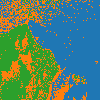

In [8]:
path = 'test.gif'
saveGIF(imgs, path)
showGIF(path)

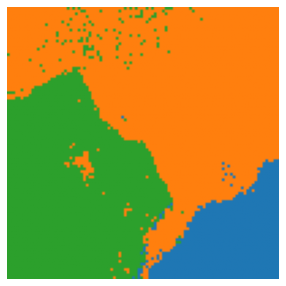

In [9]:
plotCluster(imgs, -1)